In [1]:
import pandas as pd
import Functions
from VPRM_offline.src.get_modis_point import get_modis_point
import os
import datetime
from pyhdf.SD import SD, SDC
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%run Functions

In [2]:
cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
year = 2018
StationDataPath = cwd + 'data/HH_Data_small/'

stations_file = cwd + 'Stations.csv'
years_file = cwd + 'Station_years.csv'
MODISpath_old = cwd + 'data/MODIS_OSLO/'
MODISpath_new = cwd + 'data/MODIS/'


In [3]:
stations, list_stations = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)
list_stations

array(['FI-Hyy', 'FI-Let', 'FI-Qvd', 'SE-Lnn', 'SE-Ros', 'SE-Svb',
       'SE-Deg', 'SE-Htm', 'SE-Nor'], dtype=object)

In [5]:
df_old = pd.DataFrame()
for sitename in list_stations: 
    lon = stations.loc[sitename, 'Longitude']
    lat = stations.loc[sitename, 'Latitude']
    tile = [stations.loc[sitename, 'tile_h'], stations.loc[sitename, 'tile_v']]
    #get evi of old modis 
    data = get_modis_point(year=year, lat = lat, lon = lon, tile = tile, MODISpath = MODISpath_old, sitename = sitename)
    evi_old = data[1]    
    df_old[sitename + '_EVI'] = evi_old
    

[61.84166667] [24.29166667]
[60.64166667] [23.95833333]
[60.29166667] [22.38333333]
[58.33333333] [13.1]
[64.16666667] [19.73333333]
[64.25] [19.76666667]
[64.175] [19.55]
[56.09166667] [13.41666667]
[60.08333333] [17.475]


In [9]:
# get modis data from modis 500m for year and all stations in different tiles 
dirListing = os.listdir(MODISpath_new)
dirListing.remove('.ipynb_checkpoints')
evi_dict = {}
df = pd.DataFrame()

for folder in dirListing:
    if(folder[0:4]!=str(year)):
        pass
    else: 
        files = os.listdir(MODISpath_new + folder)
        h = int(folder.split("_h",1)[1].split("_v",1)[0])
        v = int(folder.split("_v",1)[1])
        stations, list_st = get_stations_tile_year(year,h,v)
        #get grid coordinates for new modis 
        index = [forward_mapping(*coords) for coords in [deg_to_rad(*item) for item in stations[['Latitude', 'Longitude']].values.tolist()]]
        for file in files: 
            date = str.split(file, sep = ".")[1]
            title = datetime.datetime.strptime(date[3:], '%y%j').date() 
            file_path = MODISpath_new + folder + '/'
            data = get_modis_layer(file, file_path) 
            evi = [data[x] for x in index]
            evi_dict[str(title)] = evi
        od = collections.OrderedDict(sorted(evi_dict.items()))
        df_t = pd.DataFrame.from_dict(od, orient='index', columns = list_st)
        df = pd.concat([df, df_t], axis=1)
                # evi = data[(1956, 350)]#/scale_factor
  

,SE-Ros,SE-Svb,SE-Deg,SE-Nor,FI-Hyy,FI-Let,FI-Qvd,SE-Lnn,SE-Htm
2017-12-19,NaN,NaN,NaN,0.2709,-0.0017,0.0038,0.0541,0.1427,0.2143
2018-01-01,NaN,NaN,NaN,0.3083,0.1906,0.1575,0.0541,0.1427,0.3143
2018-01-17,0.0296,0.1480,0.0568,0.3084,-0.0436,0.0999,0.0315,0.1751,0.2778
2018-02-02,0.0595,0.0586,-0.0214,0.1578,0.1466,0.1445,0.0851,0.0171,0.3427
2018-02-18,0.1770,0.1031,0.0031,0.1524,0.2355,0.1658,0.0849,-0.0092,0.2596
2018-03-06,0.1708,0.2103,0.0492,0.1766,0.1617,0.1688,0.0569,0.1160,0.3597
2018-03-22,0.1315,0.1824,0.0343,0.2076,0.2430,0.1796,0.0974,0.1185,0.2738
2018-04-07,0.1086,0.1790,-0.0049,0.2553,0.2263,0.2273,0.1565,0.2186,0.2732
2018-04-23,0.2658,0.2072,0.0793,0.2626,0.2281,0.2529,0.2566,0.2355,0.3473
2018-05-09,0.2154,0.2752,0.2731,0.3050,0.2734,0.3564,0.2782,0.4143,0.3849


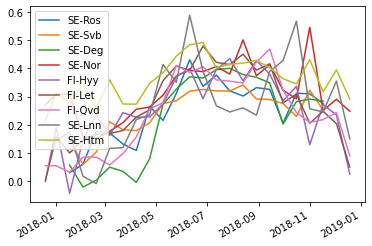

In [195]:
df.index = pd.to_datetime(df.index)
df.plot()
df

In [196]:
from datetime import datetime
date_list = pd.date_range(start="2018-01-01",end="2018-12-31", periods = 46).to_pydatetime().tolist()
df_old.index = [x.date() for x in date_list]

<AxesSubplot:>

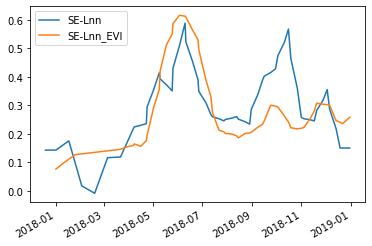

In [205]:
# comparison of old and new modis data
result = df_old.join(df, how='outer')
# result[['SE-Lnn', 'SE-Lnn_EVI']].plot()
result[['SE-Lnn', 'SE-Lnn_EVI']].interpolate(method='linear').plot()#plot(marker='o')


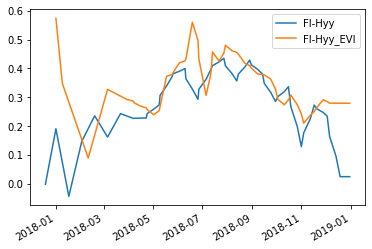

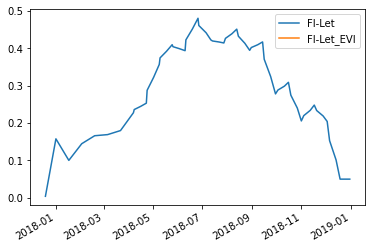

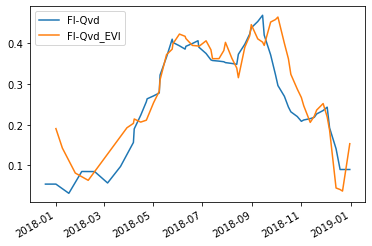

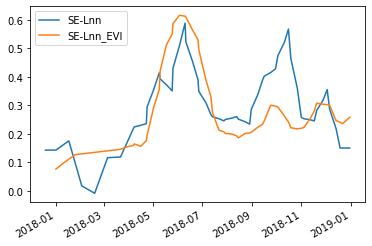

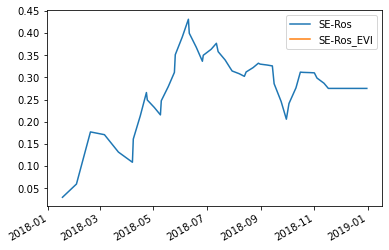

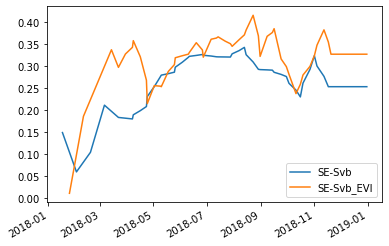

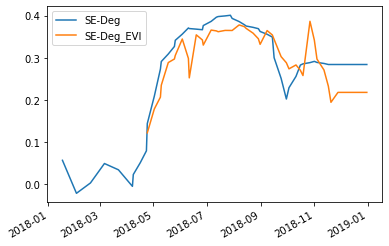

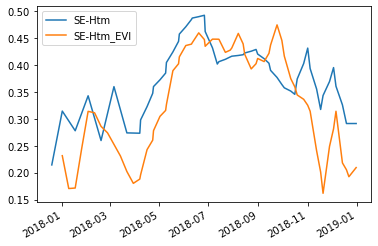

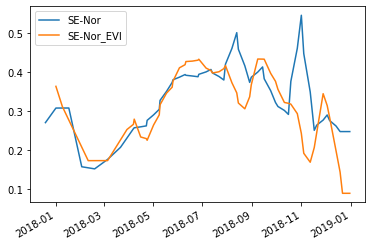

In [207]:
# comparison of stations old (_EVI) and new MODIS EVI 
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

for station in list_stations:
    ax = result[[station, station + '_EVI']].interpolate(method='linear').plot()
    fig = ax.get_figure()
    fig.savefig(cwd + 'figures/' + str(station)+'.png')
    

In [208]:
# read and clean csv files of stations LNN and NOR

In [209]:
path_LSWI_Lnn = cwd + 'data/Google_EVI_LSWI/' + 'LSWI_SE-Lnn.csv'
path_LSWI_Nor = cwd + 'data/Google_EVI_LSWI/' + 'LSWI_SE-Nor.csv'
df_Lnn_L = pd.read_csv(path_LSWI_Lnn)
df_Lnn_L['date'] = pd.to_datetime(df_Lnn_L['system:time_start'])
df_Nor_L = pd.read_csv(path_LSWI_Nor)
df_Nor_L['date'] = pd.to_datetime(df_Nor_L['system:time_start'])

<AxesSubplot:title={'center':'SE-Nor LSWI, 2017-2020, Google Earth'}, xlabel='date'>

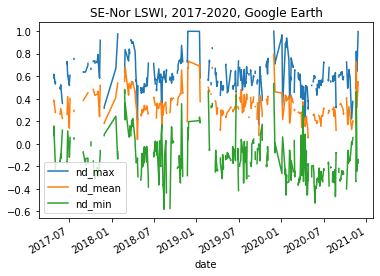

In [210]:
df_Nor_L.plot(x = 'date', title='SE-Nor LSWI, 2017-2020, Google Earth')

<AxesSubplot:title={'center':'SE-Lnn LSWI, 2017-2020, Google Earth'}, xlabel='date'>

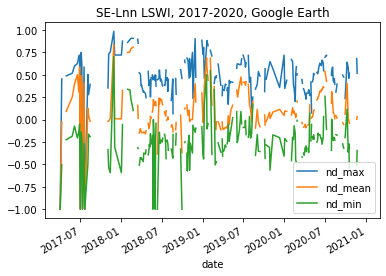

In [211]:
df_Lnn_L.plot(x = 'date', title='SE-Lnn LSWI, 2017-2020, Google Earth')

In [212]:
path_EVI_Lnn = cwd + 'data/Google_EVI_LSWI/' + 'EVI_SE-Lnn.csv'
path_EVI_Nor = cwd + 'data/Google_EVI_LSWI/' + 'EVI_SE-Nor.csv'
df_Lnn_E = pd.read_csv(path_EVI_Lnn)
df_Lnn_E['date'] = pd.to_datetime(df_Lnn_E['system:time_start'])

df_Nor_E = pd.read_csv(path_EVI_Nor)
df_Nor_E['date'] = pd.to_datetime(df_Nor_E['system:time_start'])


In [213]:
cols_list = list(df_Nor_E.columns[1:4])
print(cols_list)
for i in cols_list:
    df_Nor_E[i]= df_Nor_E[i].str.replace(',', '')

['constant_max', 'constant_mean', 'constant_min']


In [214]:
df_Nor_E[cols_list]= df_Nor_E[cols_list].astype(float)
for i in cols_list:
    df_Nor_E[df_Nor_E[i] > 1] = np.nan
    df_Nor_E[df_Nor_E[i] < 0] = np.nan

<AxesSubplot:title={'center':'SE-Nor EVI, 2017-2020, Google Earth'}, xlabel='date'>

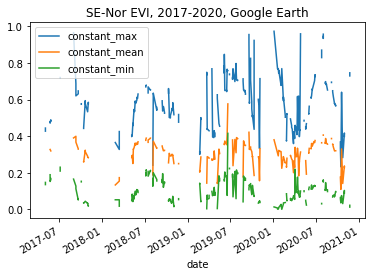

In [216]:
df_Nor_E.plot(x = 'date', title='SE-Nor EVI, 2017-2020, Google Earth')

In [217]:
cols_list = list(df_Lnn_E.columns[1:4])
print(cols_list)
for i in cols_list:
    df_Lnn_E[i]= df_Lnn_E[i].str.replace(',', '')


['constant_max', 'constant_mean', 'constant_min']


In [218]:
df_Lnn_E[cols_list]= df_Lnn_E[cols_list].astype(float)

for i in cols_list:
    df_Lnn_E[df_Lnn_E[i] > 1] = np.nan
    df_Lnn_E[df_Lnn_E[i] < 0] = np.nan

<AxesSubplot:title={'center':'SE-Lnn EVI, 2017-2020, Google Earth'}, xlabel='date'>

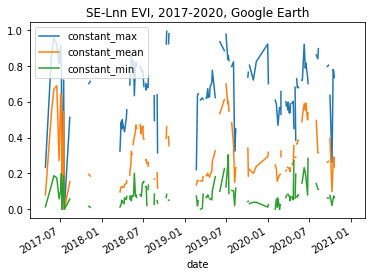

In [219]:
df_Lnn_E.plot(x = 'date', title='SE-Lnn EVI, 2017-2020, Google Earth')

In [228]:
# df_Lnn_E = df_Lnn_E[df_Lnn_E['date'].year == '2018']
df_Lnn_E['year'] = pd.DatetimeIndex(df_Lnn_E['date']).year
df_Lnn_E_2018 = df_Lnn_E[df_Lnn_E['year']==2018]

<AxesSubplot:title={'center':'SE-Lnn EVI, 2018, Google Earth interpolated'}, xlabel='date'>

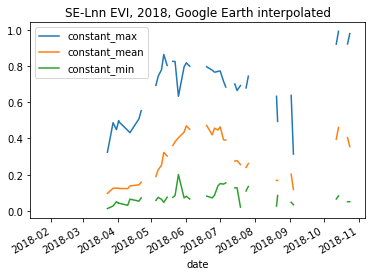

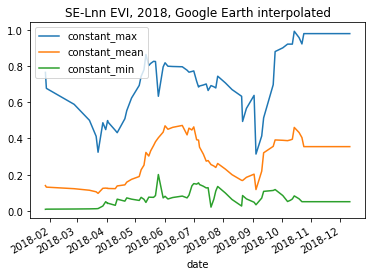

In [229]:
df_Lnn_E_2018 = df_Lnn_E_2018.drop(columns=['year'])
df_Lnn_E_2018.plot(x = 'date', title='SE-Lnn EVI, 2018, Google Earth interpolated')
df_Lnn_E_2018.interpolate(method='linear').plot(x = 'date', title='SE-Lnn EVI, 2018, Google Earth interpolated')

In [222]:
df_Lnn_E_2018= df_Lnn_E_2018.interpolate(method='linear')
df_Lnn_E_2018

,system:time_start,constant_max,constant_mean,constant_min,date
28,"Jan 17, 2018",NaN,NaN,NaN,2018-01-17
29,"Jan 18, 2018",NaN,NaN,NaN,2018-01-18
30,"Jan 25, 2018",NaN,NaN,NaN,2018-01-25
31,"Jan 27, 2018",0.7650,0.1400,0.0090,2018-01-27
32,"Jan 28, 2018",0.6768,0.1314,0.0098,2018-01-28
...,...,...,...,...,...
110,"Oct 14, 2018",0.9920,0.4610,0.0830,2018-10-14
111,"Oct 19, 2018",0.9570,0.4330,0.0670,2018-10-19
112,"Oct 22, 2018",0.9220,0.4050,0.0510,2018-10-22
113,"Oct 24, 2018",0.9790,0.3550,0.0510,2018-10-24


<AxesSubplot:>

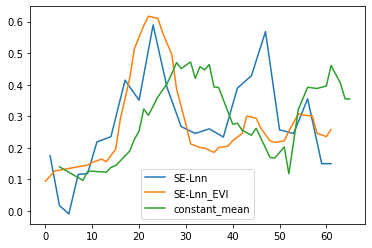

In [223]:
df_LNN_EVI_compare = result[['SE-Lnn', 'SE-Lnn_EVI']].iloc[2:]
# df_LNN_EVI_compare['Se-Lnn_GE'] = df_Lnn_E_2018['constant_mean'].interpolate(method='linear')
df_LNN_EVI_compare = df_LNN_EVI_compare.interpolate(method='linear')#.plot()

df_LNN_EVI_compare.reset_index(drop=True, inplace=True)
df_Lnn_E_2018.reset_index(drop=True, inplace=True)

df = pd.concat( [df_LNN_EVI_compare, df_Lnn_E_2018['constant_mean']], axis=1) 
df.plot()


In [224]:
df.describe()

,SE-Lnn,SE-Lnn_EVI,constant_mean
count,61.000000,62.000000,63.000000
mean,0.288311,0.273498,0.284913
std,0.136479,0.139001,0.122388
min,-0.009200,0.094475,0.097000
25%,0.224233,0.187258,0.168500
50%,0.260200,0.234765,0.278000
75%,0.389200,0.302060,0.392000
max,0.589200,0.616795,0.472000


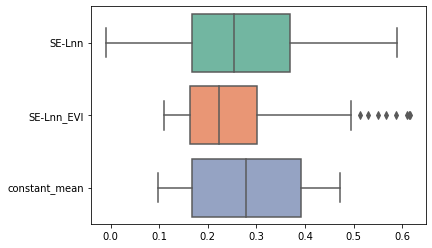

In [97]:
ax = sns.boxplot(data=df, orient="h", palette="Set2")

In [122]:
#Test for normal distribution
for i in df.columns: 
    stat, p = stats.shapiro(df[i])
    print(i, p)
# df.iloc[:,1]
# we cannot reject the normality assumtion...



SE-Lnn 0.47114458680152893
SE-Lnn_EVI 1.0
constant_mean 1.0


In [124]:
#Test for significant difference (no normality) 
stat, p = stats.wilcoxon(df.iloc[:,0],df.iloc[:,1])
print(p)
stat, p = stats.wilcoxon(df.iloc[:,1],df.iloc[:,2])
print(p)
stat, p = stats.wilcoxon(df.iloc[:,0],df.iloc[:,2])
print(p)
# When the p-value is less than 0.05, we reject the null hypothesis. 
# We then have sufficient evidence to say that the true mean is not equal between the two groups 
# IN the first two cases we cannot reject the null hypothesis

0.576190992277503
0.18712272115935413
0.04062078456188951


In [137]:
#Test for significant difference (normality) 
stat, p = stats.ttest_rel(df.iloc[:,0],df.iloc[:,1], nan_policy='omit')
print(p)
stat, p = stats.ttest_rel(df.iloc[:,1],df.iloc[:,2], nan_policy='omit')
print(p)
stat, p = stats.ttest_rel(df.iloc[:,0],df.iloc[:,2], nan_policy='omit')
print(p)
# When the p-value is less than 0.05, we reject the null hypothesis. 
# We then have sufficient evidence to say that the true mean is not equal between the two groups 
# In all we cannot reject the null hypothesis, this means we cannot assume that the interpolatet EVI data 
# from all three data sources for station SE-Lnn is significantly different 

0.6898118215540534
0.36952414020012636
0.6192135499510034


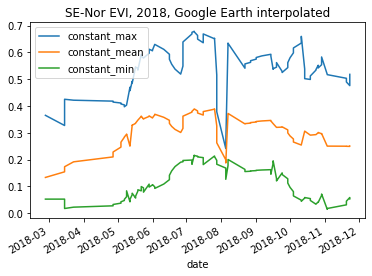

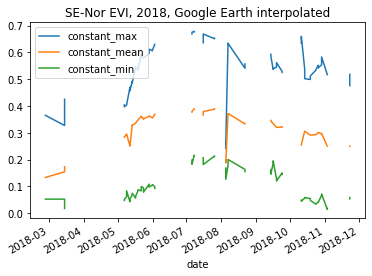

In [226]:
# do the same for SE-Nor 
df_Nor_E['year'] = pd.DatetimeIndex(df_Nor_E['date']).year
df_Nor_E_2018 = df_Nor_E[df_Nor_E['year']==2018]
df_Nor_E_2018 = df_Nor_E_2018.drop(columns=['year'])
df_Nor_E_2018.interpolate(method='linear').plot(x = 'date', title='SE-Nor EVI, 2018, Google Earth interpolated')
df_Nor_E_2018.plot(x = 'date', title='SE-Nor EVI, 2018, Google Earth interpolated')

df_Nor_EVI_compare = result[['SE-Nor', 'SE-Nor_EVI']].iloc[2:]
df_Nor_EVI_compare = df_Nor_EVI_compare.interpolate(method='linear')#.plot()

df_Nor_E_2018 = df_Nor_E_2018.set_index('date')


<AxesSubplot:title={'center':'Station SE-Nor, 2018, three sources of EVI'}>

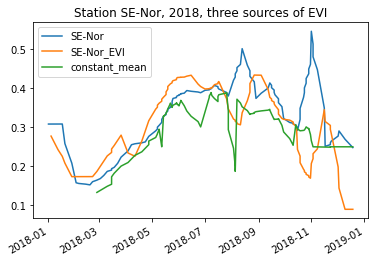

In [182]:
# df_Nor_E_2018
df=df_Nor_EVI_compare.merge(df_Nor_E_2018['constant_mean'], how='outer', left_index=True, right_index=True)
df = df.dropna(axis = 0, how = 'all')
df = df.interpolate(method='linear')

df.plot(title = 'Station SE-Nor, 2018, three sources of EVI')

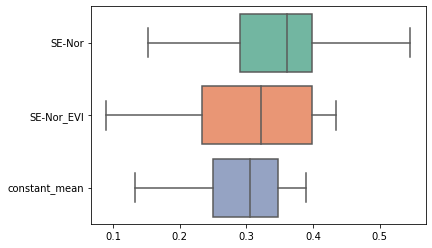

In [183]:
df.describe()
ax = sns.boxplot(data=df, orient="h", palette="Set2")

In [186]:
#Test for normal distribution
for i in df.columns: 
    stat, p = stats.shapiro(df[i])
    print(i, p)
# df.iloc[:,1]
# we can reject the normality assumtion only for the first, the other two have a p value geater than 0.05

SE-Nor 0.000941078586038202
SE-Nor_EVI 1.0
constant_mean 1.0


In [185]:
#Test for significant difference (no normality) 
stat, p = stats.wilcoxon(df.iloc[:,0],df.iloc[:,1])
print(p)
stat, p = stats.wilcoxon(df.iloc[:,1],df.iloc[:,2])
print(p)
stat, p = stats.wilcoxon(df.iloc[:,0],df.iloc[:,2])
print(p)
# When the p-value is less than 0.05, we reject the null hypothesis. 
# We then have sufficient evidence to say that the true mean is not equal between the two groups 
# IN the first case we cannot reject the null hypothesis

0.4466508687948204
2.319904323765056e-08
1.4543464619828302e-21


In [187]:
#Test for significant difference (normality) 
stat, p = stats.ttest_rel(df.iloc[:,0],df.iloc[:,1], nan_policy='omit')
print(p)
stat, p = stats.ttest_rel(df.iloc[:,1],df.iloc[:,2], nan_policy='omit')
print(p)
stat, p = stats.ttest_rel(df.iloc[:,0],df.iloc[:,2], nan_policy='omit')
print(p)
# When the p-value is less than 0.05, we reject the null hypothesis. 
# We then have sufficient evidence to say that the true mean is not equal between the two groups 
# In all we can reject the null hypothesis, this means we can assume the data stems from different groups

0.00219233432762519
1.564062757657897e-05
2.202514396478432e-16


In [4]:
# getting the sentinel2 evi and lswi as csv with filtered out above 1, and below -1 
outpath = cwd + 'data/Sentinel2/'

path_EVI_Lnn = cwd + 'data/Google_EVI_LSWI/' + 'EVI_SE-Lnn.csv'
path_LSWI_Lnn = cwd + 'data/Google_EVI_LSWI/' + 'LSWI_SE-Lnn.csv'

df_Lnn_E = pd.read_csv(path_EVI_Lnn)
# print(df_Lnn_E.shape)

df_Lnn_L = pd.read_csv(path_LSWI_Lnn)

cols_list = list(df_Lnn_E.columns[1:4])
print(cols_list)
for i in cols_list:
    df_Lnn_E[i]= df_Lnn_E[i].str.replace(',', '')
    
df_Lnn_E[cols_list]= df_Lnn_E[cols_list].astype(float)

for i in cols_list:
    df_Lnn_E[df_Lnn_E[i] > 1] = np.nan
    df_Lnn_E[df_Lnn_E[i] < 0] = np.nan

# print(df_Lnn_L.shape)
 
df_Lnn_E = df_Lnn_E[df_Lnn_E['constant_mean'].notna()]
df_Lnn_L = df_Lnn_L[df_Lnn_L['nd_mean'].notna()]

output_df = pd.merge(df_Lnn_E, df_Lnn_L)
# print(output_df.shape)
output_df['Date'] = pd.to_datetime(output_df['system:time_start'])#, format='%d-%m-%Y')


output_df.to_csv(outpath+'SE-Lnn_unf_500m.csv', index = False, header=True)

['constant_max', 'constant_mean', 'constant_min']


In [5]:
path_EVI_Nor = cwd + 'data/Google_EVI_LSWI/' + 'EVI_SE-Nor.csv'
path_LSWI_Nor = cwd + 'data/Google_EVI_LSWI/' + 'LSWI_SE-Nor.csv'

df_Nor_E = pd.read_csv(path_EVI_Nor)
# print(df_Nor_E.head)
df_Nor_L = pd.read_csv(path_LSWI_Nor)
# print(df_Nor_L.head)
# output_df1 = pd.merge(df_Nor_E, df_Nor_L)

cols_list = list(df_Nor_E.columns[1:4])
print(cols_list)
for i in cols_list:
    df_Nor_E[i]= df_Nor_E[i].str.replace(',', '')

df_Nor_E[cols_list]= df_Nor_E[cols_list].astype(float)

for i in cols_list:
    df_Nor_E[df_Nor_E[i] > 1] = np.nan
    df_Nor_E[df_Nor_E[i] < 0] = np.nan

df_Nor_E = df_Nor_E[df_Nor_E['constant_mean'].notna()]
df_Nor_L = df_Nor_L[df_Nor_L['nd_mean'].notna()]

output_df1 = pd.concat([df_Nor_E, df_Nor_L.loc[:, df_Nor_L.columns != "system:time_start"]], axis = 1)

output_df1['Date'] = pd.to_datetime(output_df1['system:time_start'])#, format='%d-%m-%Y')

output_df1.to_csv(outpath+'SE-Nor_unf_500m.csv', index = False, header=True)


['constant_max', 'constant_mean', 'constant_min']


In [6]:
output_df


,system:time_start,constant_max,constant_mean,constant_min,nd_max,nd_mean,nd_min,Date
0,"Apr 30, 2017",0.234,0.080,0.014,0.488,0.092,-0.224,2017-04-30
1,"May 27, 2017",0.872,0.547,0.137,0.518,0.251,-0.185,2017-05-27
2,"Jun 6, 2017",0.956,0.669,0.187,0.597,0.397,-0.072,2017-06-06
3,"Jun 19, 2017",0.917,0.688,0.175,0.626,0.501,-0.205,2017-06-19
4,"Jun 29, 2017",0.811,0.271,0.058,0.720,0.586,-0.051,2017-06-29
...,...,...,...,...,...,...,...,...
144,"Oct 16, 2020",0.766,0.292,0.074,0.462,-0.015,-0.269,2020-10-16
145,"Oct 18, 2020",0.735,0.236,0.065,0.518,-0.040,-0.544,2020-10-18
146,"Oct 28, 2020",0.761,0.206,0.021,0.523,0.013,-0.257,2020-10-28
147,"Nov 22, 2020",0.745,0.184,0.002,0.516,0.032,-0.344,2020-11-22
